# Scrotal Pain Retrospective Study Analysis

This notebook contains the analysis of the sp_retro dataset, which includes data from patients with scrotal pain collected in 2003. The goal is to build a binary classifier to support triage decisions in a pediatric emergency room.

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# For model evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, precision_recall_curve, auc, 
                             confusion_matrix, roc_curve)

# For preprocessing and modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA

# Dla niezbalansowanych danych
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Wyciszanie ostrzeżeń
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
from helpers import read_dataset, visualize

## 1. Data Exploration

Let's examine the dataset to understand its structure, size, and characteristics.

In [3]:
data = read_dataset('sp_retro_data.xls')
print(f"Initial data shape: {data.shape}")
print("First few rows of the raw data:")
display(data.head())

Initial data shape: (409, 31)
First few rows of the raw data:


,NUMBER,AGE,HX_AS,NAUSEA,VOMIT,NAUSEA_OR_VOMIT,ABD_PAIN,ONSET,PAIN_TYPE,DURATION,...,SITE_SWELLING,COLOR,TEST_LIE,CORD_PALP,CREM_REF,TRANSILLUM,URINE_WBC,URINE_BACT,URINE_RBC,TRIAGE
0,1,LT10Y,NaN,NaN,NO,NONE,YES,NaN,NaN,LT6H,...,OSC,NaN,NaN,ABNORMAL,NaN,NaN,NaN,NaN,NaN,CLINIC
1,2,GE10Y_LE13Y,NaN,NaN,NaN,NaN,YES,SUDDEN,NaN,GE6H_LE24H,...,OSC,ERYTHEMA,NORMAL,NORMAL,YES,YES,NEG_0_5,NEG,NEG_0_5,CLINIC
2,3,GT13Y,NO,YES,YES,VOMIT,NaN,SUDDEN,NaN,GE6H_LE24H,...,TESTICLE,NORMAL,NaN,NaN,NaN,NaN,NEG_0_5,POS,NEG_0_5,CONSULT
3,4,GT13Y,NaN,NaN,YES,VOMIT,YES,NaN,CONSTANT,GT24H,...,NONE,ERYTHEMA,NaN,NORMAL,NaN,NaN,NEG_0_5,NaN,NEG_0_5,DISCHARGE
4,5,LT10Y,NaN,NaN,NO,NONE,YES,GRADUAL,NaN,LT6H,...,NONE,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DISCHARGE


In [4]:
for col in data.columns:
    if data[col].nunique() == 1:
        print(f"Column {col} has only one unique value. Dropping it.")
        data.drop(columns=[col], inplace=True)


for col in data.columns:
    if data[col].isnull().all():
        print(f"Column {col} has all values as NaN. Dropping it.")
        data.drop(columns=[col], inplace=True)

Column PMHX_URETH_INSTR has only one unique value. Dropping it.


## 2. Target Variable Binarization

We need to binarize the target variable according to the specified requirements:
- Positive class: CONSULT (most clinically important)
- Negative class: DISCHARGE + CLINIC

Rectangle(xy=(-0.4, 0), width=0.8, height=353, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=56, angle=0)


/home/mariusz/Pulpit/siwib-traditional-ml/sp_retro/helpers.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='binary_target', data=data, palette='viridis', dodge=False)


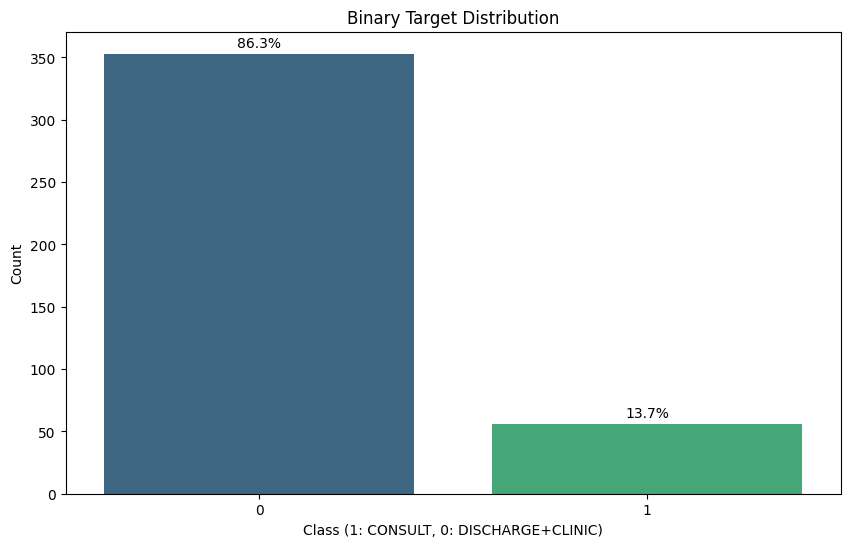

In [5]:
data['binary_target'] = data['TRIAGE'].apply(lambda x: 1 if x == 'CONSULT' else 0)
data.drop(columns=['TRIAGE'], inplace=True)

visualize(data)

## 3. Data Preprocessing

Let's prepare the data for modeling by handling missing values, encoding categorical features, and scaling numerical features.

In [6]:
# Identify numerical and categorical columns
# Exclude the original TRIAGE and the binary_target columns from the features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()

numerical_cols.remove('binary_target')

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"\nNumerical features: {numerical_cols}")
print(f"\nCategorical features: {categorical_cols}")

Number of numerical features: 1
Number of categorical features: 28

Numerical features: ['NUMBER']

Categorical features: ['AGE', 'HX_AS', 'NAUSEA', 'VOMIT', 'NAUSEA_OR_VOMIT', 'ABD_PAIN', 'ONSET', 'PAIN_TYPE', 'DURATION', 'ASSOC_UT_SX', 'HX_TRAUMA', 'HX_SPORTS', 'HX_SEX', 'PMHX_UTI', 'PMHX_SURG', 'PMHX_UT_ABN', 'TEMP', 'LOCATION', 'SITE_TENDER', 'SITE_SWELLING', 'COLOR', 'TEST_LIE', 'CORD_PALP', 'CREM_REF', 'TRANSILLUM', 'URINE_WBC', 'URINE_BACT', 'URINE_RBC']


In [7]:
# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors into a single transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Create X and y for modeling
X = data.drop('binary_target', axis=1)
y = data['binary_target']

## 4. Model Building

### 4.1 Baseline Model (Logistic Regression)

We'll start with a simple logistic regression model as our baseline.

In [8]:
def create_simple_preprocessor(X):
    """Tworzy prosty preprocessor dla modelu bazowego, który 
    jedynie obsługuje wartości kategoryczne bez skalowania danych liczbowych"""
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # Prosty preprocessor dla baseline - tylko kodowanie kategorii, bez skalowania
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Tylko imputacja dla kolumn liczbowych, bez skalowania
    numerical_transformer = SimpleImputer(strategy='median')
    
    # Combine preprocessors into a single transformer
    baseline_preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    return baseline_preprocessor

# Utwórz prosty preprocessor dla baseline modelu
baseline_preprocessor = create_simple_preprocessor(X)

# Define the baseline model using minimal preprocessing (tylko kodowanie kategorii)
baseline_model = Pipeline(steps=[
    ('preprocessor', baseline_preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'
    ))
])

print("Baseline model z minimalnym preprocessingiem został zdefiniowany.")

Baseline model z minimalnym preprocessingiem został zdefiniowany.


### 4.2 Improved Model (Gradient Boosting)

For the improved model, we'll use Gradient Boosting with feature selection and hyperparameter tuning.

In [9]:
# Improved model pipeline używający preprocessora (przetworzonych danych)
improved_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Używamy preprocessora dla improved model
    ('feature_selection', SelectKBest(f_classif, k=15)),  # Wybór najlepszych cech
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    ))
])

print("Improved model z preprocessorem oraz GradientBoostingClassifier został zdefiniowany.")

Improved model z preprocessorem oraz GradientBoostingClassifier został zdefiniowany.


In [10]:
# Zaawansowany preprocessing dla improved modelu
# Zdefiniujmy bardziej zaawansowany preprocessor
def create_advanced_model(X, y):
    """Tworzy zaawansowany model z zaawansowanymi transformacjami danych"""
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # Zaawansowany transformer dla danych numerycznych
    numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),  # Imputacja KNN zamiast median
        ('power_transform', PowerTransformer(method='yeo-johnson')),  # Lepsze niż zwykła standaryzacja dla skośnych danych
        ('quantile_transform', QuantileTransformer(output_distribution='normal', n_quantiles=100))  # Dodatkowa normalizacja rozkładu
    ])
    
    # Transformer dla danych kategorycznych - używamy OneHotEncoder z dodatkowymi opcjami
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Łączymy transformery
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    # Definiujemy zaawansowany model z PCA i selekcją cech
    advanced_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('dim_reduction', PCA(n_components=0.95)),  # Redukcja wymiarowości zachowująca 95% wariancji
        ('feature_selection', SelectKBest(f_classif, k=15)),  # Selekcja najlepszych cech
        ('classifier', GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            random_state=RANDOM_STATE
        ))
    ])
    
    return advanced_model

# Tworzymy zaawansowany model
print("\nTworzenie zaawansowanego modelu...")
advanced_model = create_advanced_model(X, y)
print("Zaawansowany model został utworzony pomyślnie.")


Tworzenie zaawansowanego modelu...
Zaawansowany model został utworzony pomyślnie.


In [11]:
# Zaawansowany preprocessing dla improved modelu z obsługą niezbalansowanych danych

# Funkcja do tworzenia modelu dla niezbalansowanych danych
def create_imbalanced_model(X, y):
    """Tworzy zaawansowany model z technikami obsługi niezbalansowanych danych"""
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include(['object', 'bool']).columns.tolist()
    
    # Zaawansowany transformer dla danych numerycznych
    numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('power_transform', PowerTransformer(method='yeo-johnson')),
        ('quantile_transform', QuantileTransformer(output_distribution='normal', n_quantiles=100))
    ])
    
    # Transformer dla danych kategorycznych - używamy OneHotEncoder zamiast TargetEncoder
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Łączymy transformery
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    # Używamy SMOTEENN jako domyślnej techniki próbkowania
    # Tworzymy zaawansowany pipeline z obsługą niezbalansowanych danych
    advanced_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampling', SMOTEENN(random_state=RANDOM_STATE)),
        ('feature_selection', SelectKBest(f_classif, k=15)),
        ('classifier', GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            random_state=RANDOM_STATE
        ))
    ])
    
    return advanced_pipeline

# Tworzymy model dostosowany do niezbalansowanych danych
print("\nTworzenie modelu dostosowanego do niezbalansowanych danych...")
imbalanced_model = create_imbalanced_model(X, y)
print("Model dla niezbalansowanych danych został utworzony pomyślnie.")

SyntaxError: '(' was never closed (372625488.py, line 7)

## 5. Model Evaluation (3× Stratified 5-fold Cross-Validation)

We'll implement the evaluation framework with 3× stratified 5-fold cross-validation and report the required metrics.

In [ ]:
# Define helper functions for the evaluation

def find_threshold_for_sensitivity(y_true, y_pred_proba, target_sensitivity=0.99):
    '''Find the threshold where sensitivity (recall) is at least the target value''',
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    idx = np.where(tpr >= target_sensitivity)[0][0]
    return thresholds[idx]

def find_threshold_for_specificity(y_true, y_pred_proba, target_specificity=0.90):
    '''Find the threshold where specificity is at least the target value''',
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    idx = np.where(1 - fpr >= target_specificity)[0][-1]
    return thresholds[idx]

def evaluate_with_custom_thresholds(model, X, y):
    # Results dictionary to store all metrics for all folds and repeats
    results = {
        'AUROC': [],
        'AUPRC': [],
        'medium_risk_threshold': [],
        'high_risk_threshold': [],
        'FNR': [],
        'FPR': [],
        'decision_percentage': []
    }
    
    # Repeat stratified 5-fold CV 3 times
    for rep in range(3):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE + rep)
        
        fold = 1
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Get probabilities for the positive class
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate AUROC and AUPRC
            auroc = roc_auc_score(y_test, y_pred_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            auprc = auc(recall, precision)
            
            # Find thresholds for medium and high risk
            medium_risk_threshold = find_threshold_for_sensitivity(y_test, y_pred_proba, 0.99)
            high_risk_threshold = find_threshold_for_specificity(y_test, y_pred_proba, 0.90)
            
            # DEBUG: Wypisz wartości progów
            print(f"DEBUG: Medium risk threshold: {medium_risk_threshold:.6f}")
            print(f"DEBUG: High risk threshold: {high_risk_threshold:.6f}")
            
            # Apply the thresholds to make decisions
            decisions = np.full(len(y_test), 'grey_zone', dtype=object)  # Default to grey zone
            decisions[y_pred_proba < medium_risk_threshold] = 'negative'
            decisions[y_pred_proba >= high_risk_threshold] = 'positive'
            
            # DEBUG: Sprawdź ilość przypadków w każdej kategorii
            print(f"DEBUG: Negative decisions: {np.sum(decisions == 'negative')}")
            print(f"DEBUG: Grey zone decisions: {np.sum(decisions == 'grey_zone')}")
            print(f"DEBUG: Positive decisions: {np.sum(decisions == 'positive')}")
            
            # Calculate metrics for decisions
            decision_made = decisions != 'grey_zone'
            decision_percentage = np.mean(decision_made) * 100
            
            # DEBUG: Sprawdź ilość przypadków gdzie decyzja została podjęta
            print(f"DEBUG: Total decisions made: {np.sum(decision_made)} out of {len(y_test)}")
            
            # For FNR and FPR, only consider cases where a decision was made
            y_decided = y_test[decision_made]
            predictions_decided = np.where(decisions[decision_made] == 'positive', 1, 0)
            
            # DEBUG: Sprawdź wartości y_decided i predictions_decided
            print(f"DEBUG: y_decided values: {np.sum(y_decided == 1)} positive, {np.sum(y_decided == 0)} negative")
            print(f"DEBUG: predictions_decided values: {np.sum(predictions_decided == 1)} positive, {np.sum(predictions_decided == 0)} negative")
            
            if len(y_decided) > 0 and sum(y_decided) > 0 and sum(predictions_decided) > 0:
                cm = confusion_matrix(y_decided, predictions_decided)
                print("DEBUG: Confusion Matrix:")
                print(cm)
                
                if cm.shape == (2, 2):
                    tn, fp, fn, tp = cm.ravel()
                    print(f"DEBUG: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
                    
                    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
                    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                    
                    print(f"DEBUG: FNR calculation: {fn} / ({fn} + {tp}) = {fnr:.4f}")
                    print(f"DEBUG: FPR calculation: {fp} / ({fp} + {tn}) = {fpr:.4f}")
                else:
                    # Możliwe, że mamy problem z kształtem macierzy pomyłek
                    print(f"DEBUG: Nieprawidłowy kształt macierzy pomyłek: {cm.shape}")
                    fnr = 0
                    fpr = 0
            else:
                print("DEBUG: Nie można obliczyć macierzy pomyłek - brak odpowiednich danych")
                print(f"DEBUG: len(y_decided)={len(y_decided)}, sum(y_decided)={sum(y_decided)}, sum(predictions_decided)={sum(predictions_decided)}")
                fnr = 0
                fpr = 0
            
            # Store results
            results['AUROC'].append(auroc)
            results['AUPRC'].append(auprc)
            results['medium_risk_threshold'].append(medium_risk_threshold)
            results['high_risk_threshold'].append(high_risk_threshold)
            results['FNR'].append(fnr)
            results['FPR'].append(fpr)
            results['decision_percentage'].append(decision_percentage)
            
            print(f"Repeat {rep+1}, Fold {fold}: AUROC={auroc:.4f}, AUPRC={auprc:.4f}, Decision %={decision_percentage:.2f}%, FNR={fnr:.4f}, FPR={fpr:.4f}")
            print("-" * 80)
            fold += 1
    
    # Return average results
    avg_results = {key: np.mean(values) for key, values in results.items()}
    std_results = {key + '_std': np.std(values) for key, values in results.items()}
    return {**avg_results, **std_results}, results

print("Evaluation functions defined.")

## 6. Evaluate Models

Let's evaluate both our baseline and improved models using the evaluation framework.

In [ ]:
# Evaluate the baseline model
print("Evaluating baseline model (Logistic Regression)...")
baseline_avg_results, baseline_all_results = evaluate_with_custom_thresholds(baseline_model, X, y)

# Display baseline model results
print("\nBaseline Model Average Results:")
for key, value in baseline_avg_results.items():
    if not key.endswith('_std'):
        std_key = key + '_std'
        std_value = baseline_avg_results.get(std_key, 0)
        print(f"{key}: {value:.4f} ± {std_value:.4f}")

In [ ]:
# Evaluate the improved model
print("\nEvaluating improved model (Gradient Boosting)...")
improved_avg_results, improved_all_results = evaluate_with_custom_thresholds(improved_model, X, y)

# Display improved model results
print("\nImproved Model Average Results:")
for key, value in improved_avg_results.items():
    if not key.endswith('_std'):
        std_key = key + '_std'
        std_value = improved_avg_results.get(std_key, 0)
        print(f"{key}: {value:.4f} ± {std_value:.4f}")

## 7. Compare Models

Let's visualize the performance comparison between our baseline and improved models.

In [ ]:
# Create a comparison dataframe
comparison_metrics = ['AUROC', 'AUPRC', 'FNR', 'FPR', 'decision_percentage']
comparison_data = {
    'Metric': comparison_metrics,
    'Baseline Model': [baseline_avg_results[metric] for metric in comparison_metrics],
    'Improved Model': [improved_avg_results[metric] for metric in comparison_metrics],
}

comparison_df = pd.DataFrame(comparison_data).set_index('Metric')
print("Model Comparison:")
display(comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 8))

# Bar chart for AUROC and AUPRC
plt.subplot(2, 2, 1)
comparison_df.loc[['AUROC', 'AUPRC']].plot(kind='bar', ax=plt.gca())
plt.title('AUROC and AUPRC Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.ylabel('Score')

# Bar chart for FNR and FPR
plt.subplot(2, 2, 2)
comparison_df.loc[['FNR', 'FPR']].plot(kind='bar', ax=plt.gca())
plt.title('FNR and FPR Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.ylabel('Rate')

# Bar chart for decision percentage
plt.subplot(2, 2, 3)
comparison_df.loc[['decision_percentage']].plot(kind='bar', ax=plt.gca())
plt.title('Decision Percentage Comparison')
plt.xticks(rotation=0)
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()